# Empirical Analysis

***

## The following analyses are performed:

- Convergence study as N increases
- Confidence interval width behavior
- Sensitivity to volatility
- Sensitivity to maturity
- Runtime scaling analysis

### Convergence Study

Error $\propto$ $\frac{1}{\sqrt{N}}$

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time

from src.stochastic_process import GeometricBrownianMotion
from src.payoffs import EuropeanCall
from src.monte_carlo import MonteCarloPricer
from src.black_scholes import call_price

# Parameters
S0, K, r, sigma, T = 100, 100, 0.05, 0.2, 1

gbm = GeometricBrownianMotion(S0, r, sigma, T)
call = EuropeanCall(K)
pricer = MonteCarloPricer(gbm, call)

bs = call_price(S0, K, r, sigma, T)

simulation_sizes = [1_000, 5_000, 10_000, 50_000, 100_000, 200_000]

prices = []
errors = []
ci_widths = []
runtimes = []

for n in simulation_sizes:
    start = time.time()
    result = pricer.price(n_simulations=n)
    end = time.time()

    prices.append(result["price"])
    errors.append(abs(result["price"] - bs))
    ci_width = result["confidence_interval"][1] - result["confidence_interval"][0]
    ci_widths.append(ci_width)
    runtimes.append(end - start)

#### Convergence to True Price

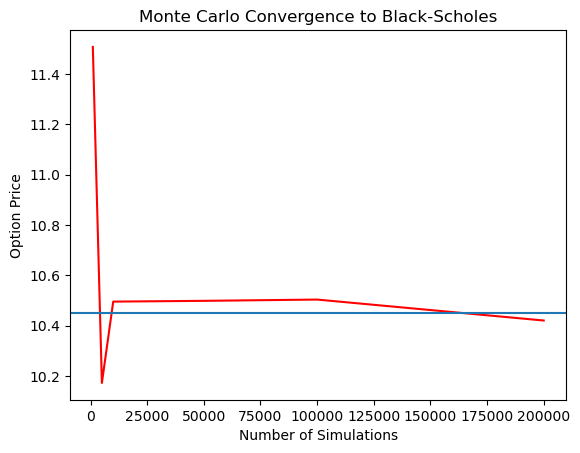

In [19]:
plt.figure()
plt.plot(simulation_sizes, prices,'r')
plt.axhline(bs)
plt.xlabel("Number of Simulations")
plt.ylabel("Option Price")
plt.title("Monte Carlo Convergence to Black-Scholes")
plt.savefig('MC_vs_BS.png',dpi=300)
plt.show()

#### Error Decay

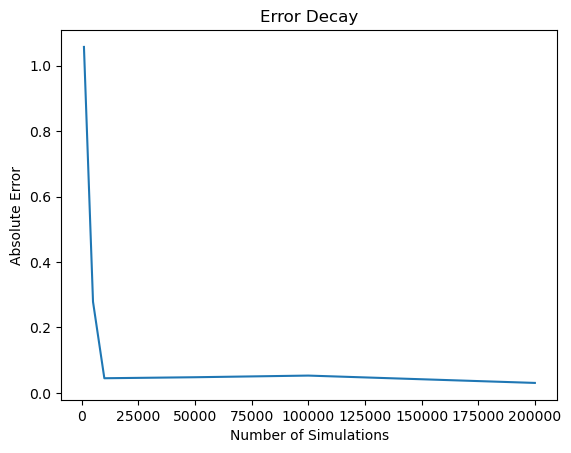

In [20]:
plt.figure()
plt.plot(simulation_sizes, errors)
plt.xlabel("Number of Simulations")
plt.ylabel("Absolute Error")
plt.title("Error Decay")
plt.savefig('MC_error.png',dpi=300)
plt.show()

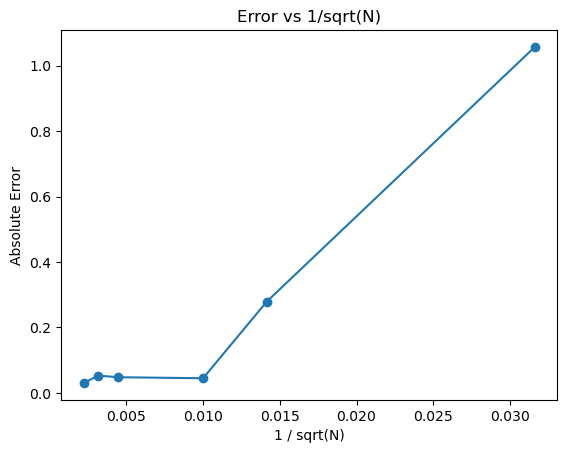

In [21]:
inv_sqrt_N = 1 / np.sqrt(simulation_sizes)

plt.figure()
plt.plot(inv_sqrt_N, errors, marker='o')
plt.xlabel("1 / sqrt(N)")
plt.ylabel("Absolute Error")
plt.title("Error vs 1/sqrt(N)")
plt.savefig('MC_error2.png',dpi=300)
plt.show()

Fit Linear Regression

In [23]:
coeffs = np.polyfit(inv_sqrt_N, errors, 1)
slope, intercept = coeffs

print("Slope:", slope)
print("Intercept:", intercept)

Slope: 35.21990300844994
Intercept: -0.1333636475903927


#### CI Width Decay

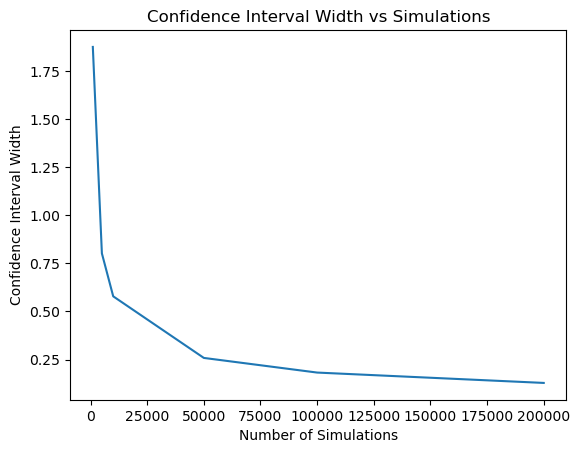

In [24]:
plt.figure()
plt.plot(simulation_sizes, ci_widths)
plt.xlabel("Number of Simulations")
plt.ylabel("Confidence Interval Width")
plt.title("Confidence Interval Width vs Simulations")
plt.savefig('MC_conf_width.png',dpi=300)
plt.show()

#### Volatility Sweep

Under the Black–Scholes model, call price is increasing and convex in $\sigma$.

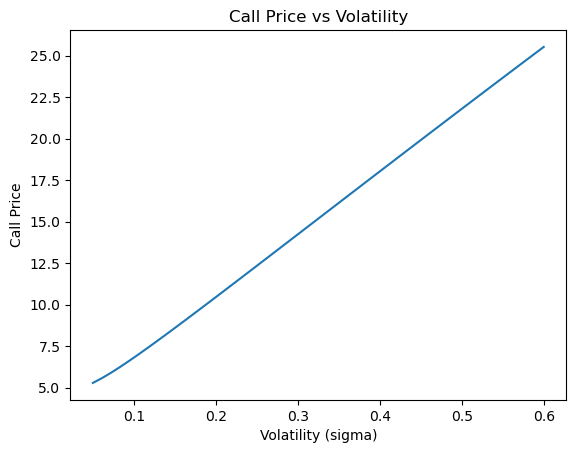

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from src.black_scholes import call_price

S0, K, r, T = 100, 100, 0.05, 1

sigmas = np.linspace(0.05, 0.6, 50)
prices = [call_price(S0, K, r, s, T) for s in sigmas]

plt.figure()
plt.plot(sigmas, prices)
plt.xlabel("Volatility (sigma)")
plt.ylabel("Call Price")
plt.title("Call Price vs Volatility")
plt.savefig('call_vs_vol.png',dpi=300)
plt.show()

#### Maturity Sensitivity
For calls, longer maturity → usually higher value.

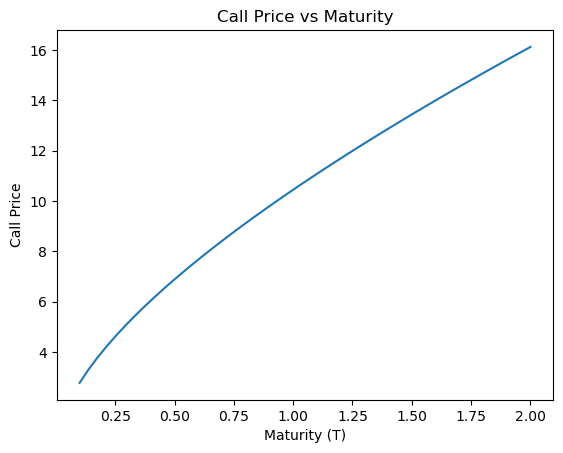

In [26]:
Ts = np.linspace(0.1, 2.0, 50)
prices_T = [call_price(S0, K, r, 0.2, t) for t in Ts]

plt.figure()
plt.plot(Ts, prices_T)
plt.xlabel("Maturity (T)")
plt.ylabel("Call Price")
plt.title("Call Price vs Maturity")
plt.savefig('call_vs_time.png',dpi=300)
plt.show()

#### 3D Surface (Volatility–Maturity Surface)

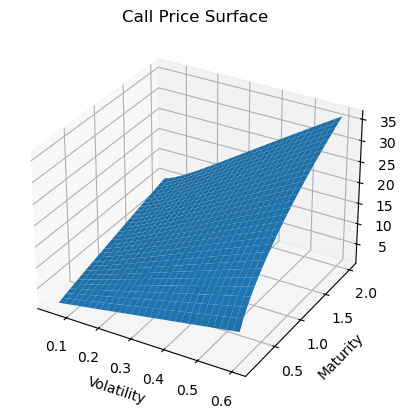

In [27]:
from mpl_toolkits.mplot3d import Axes3D

sigmas = np.linspace(0.05, 0.6, 30)
Ts = np.linspace(0.1, 2.0, 30)

Sigma_grid, T_grid = np.meshgrid(sigmas, Ts)

Z = np.zeros_like(Sigma_grid)

for i in range(len(Ts)):
    for j in range(len(sigmas)):
        Z[i, j] = call_price(S0, K, r, Sigma_grid[i, j], T_grid[i, j])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Sigma_grid, T_grid, Z)

ax.set_xlabel("Volatility")
ax.set_ylabel("Maturity")
ax.set_zlabel("Call Price")

plt.title("Call Price Surface")
plt.savefig('call_3d.png',dpi=300)
plt.show()

#### Runtime Scaling Analysis

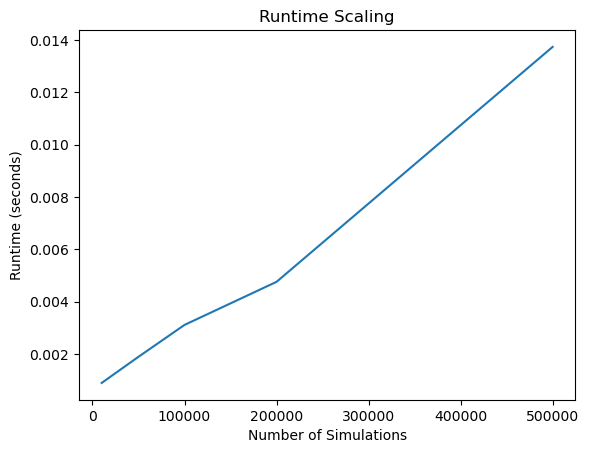

In [28]:
import time

sizes = [10_000, 50_000, 100_000, 200_000, 500_000]
times = []

for n in sizes:
    start = time.time()
    pricer.price(n)
    end = time.time()
    times.append(end - start)

plt.figure()
plt.plot(sizes, times)
plt.xlabel("Number of Simulations")
plt.ylabel("Runtime (seconds)")
plt.title("Runtime Scaling")
plt.savefig('MC_run.png',dpi=300)
plt.show()

***

## Supplement Materials

***

### Variance Reduction (Antithetic Variates)

"Antithetic variates reduce variance by inducing negative correlation between paired paths, but effectiveness depends on payoff convexity and moneyness"

- Standard Monte Carlo: $Z \sim \mathcal{N}(0,1)$
- Antithetic Monte Carlo: $Z$ and $-Z$

This induces negative correlation between paths and reduces estimator variance.


In [29]:
result_standard = pricer.price(100_000, random_state=42)
result_anti = pricer.price(100_000, random_state=42, antithetic=True)

print("Standard MC std_error:", result_standard["std_error"])
print("Antithetic MC std_error:", result_anti["std_error"])

Standard MC std_error: 0.046769902520818175
Antithetic MC std_error: 0.03307688091107499


In [8]:
print("Reduction %:", (1 - result_anti["std_error"]/result_standard["std_error"])*100) 

Reduction %: 29.2774217428573


### Variance Reduction (Control Variates)

"We want to reduce variance using a control variable whose expectation we know exactly. Under GBM, the discounted terminal stock price has known expectation: $\mathbb{E}[e^{-rT}S_T] = S_0$."

We use $\hat{V}_{CV}​=\hat{V}_{MC}​+\beta(\hat{C}_{MC}​−C_{BS}​)$ where
- $C_{BS}​$ is known
- $\hat{C}_{MC}$ is correlated estimator
- optimal $\beta$ minimizes variance

Let discounted payoff $X=e^{−rT} max(S_T​−K,0)$ and discounted $S_T$ is​ $Y=e^{−rT} S_T$ with $\mathbb{E}[Y]=S_0$

Control variate estimator: $\hat{V}_{CV​}=X-\beta(Y-\mathbb{E}[Y])$

Optimal coefficient: $\beta^* = \frac{Cov(X,Y)}{Var(Y)}$



In [9]:
result_standard = pricer.price(100_000, random_state=42)
result_cv = pricer.price(100_000, random_state=42, control_variate=True)

print("Standard SE:", result_standard["std_error"])
print("Control Variate SE:", result_cv["std_error"])

Standard SE: 0.046769902520818175
Control Variate SE: 0.017875042572763494


In [10]:
print("Reduction %:", (1 - result_cv["std_error"]/result_standard["std_error"])*100) 

Reduction %: 61.78088554961821


***

## Delta via the Pathwise Derivative method

Delta Definition $\Delta = \frac{\delta V}{\delta S_0}$

For a European call: $\frac{\delta S_T}{\delta S_0} = \frac{S_T}{S_0}$

In [ ]:
from src.black_scholes import call_delta

mc_delta = pricer.delta_pathwise(200_000, random_state=42)
bs_delta = call_delta(100, 100, 0.05, 0.2, 1)

print("Monte Carlo Delta:", mc_delta)
print("Black-Scholes Delta:", bs_delta)

## Vega via the Pathwise Derivative method

Under the Black–Scholes model, volatility enters both:

- Drift term (via $-0.5\sigma^2T$)

- Diffusion term (via $\sigma\sqrt{T} Z$)

Compute $\frac{\delta S_T}{\delta \sigma}$

In [ ]:
from src.black_scholes import call_vega

mc_vega = pricer.vega_pathwise(300_000, random_state=42)
bs_vega = call_vega(100, 100, 0.05, 0.2, 1)

print("Monte Carlo Vega:", mc_vega)
print("Black-Scholes Vega:", bs_vega)

***

## Implied Volatility Solver
Estimating volatility from market price etc.

In [ ]:
from src.black_scholes import call_price
from src.implied_vol import implied_vol_call

true_sigma = 0.2

market_price = call_price(100, 100, 0.05, true_sigma, 1)

iv = implied_vol_call(100, 100, 0.05, 1, market_price)

print("Recovered IV:", iv)

***

## Quasi Monte Carlo (QMC)

using Sobol sequences we upgrade convergence from: $\mathcal{O}(\sqrt{N})$ to $\mathcal{O}(logN/N)$

- Standard MC: Draw $Z \sim \mathcal{N}(0,1)$

- QMC: Generate Sobol sequence $U \in (0,1)$ and transform via inverse CDF: $Z=\Phi^{-1}(U)$ then simulate as usual.

Sobol sequences are low-discrepancy sequences, not random.

In [ ]:
n = 2**14

standard = pricer.price(n, random_state=42)
sobol = pricer.price_sobol(n)

print("Standard MC price:", standard["price"])
print("Standard MC SE:", standard["std_error"])

print("Sobol MC price:", sobol["price"])
print("Sobol MC SE:", sobol["std_error"])